# Exploring Metis Data within Sunpy ecosystem

*Welcome to the data analysis tutorial for the **Metis** instrument aboard the **ESA Solar Orbiter** mission.*

## The Metis Instrument
[Metis](https://metis.oato.inaf.it/instrument.html) is the multi-wavelength coronagraph designed to observe the solar corona **simultaneously in two spectral bands:**

                                 
- **Visible Light (VL) channel:** measures the polarized white-light emission (K-corona) in the 580–640 nm range, produced by Thomson scattering of photospheric photons by free coronal electrons.
- **Ultraviolet (UV) channel:** detects the narrowband monochromatic Lyman-α line at 121.6 nm, emitted by neutral hydrogen atoms in the extended corona.  
  *Note: the same spectral line is observed on-disk by EUI/HRILYA, also onboard Solar Orbiter.*

The Metis field of view (FOV) spans a range from 1.7 Rs to 10 Rs depending on the Solar Orbiter distance from the Sun.

**References:**
* *Metis instrument paper*:  [Antonucci et al., 2020](https://www.aanda.org/articles/aa/ref/2020/10/aa35338-19/aa35338-19.html)
* *Metis instrument page*: [https://metis.oato.inaf.it/](https://metis.oato.inaf.it/)
* *Metis Data Product Description Document*: https://metis.oato.inaf.it/docs/METIS-OATO-SPE-021_2.2_Solar_Orbiter_Metis_Data_Product_Description_Document.pdf
* *Solar Orbiter Mission page*: https://sci.esa.int/web/solar-orbiter/
* *Solar Orbiter Archive*: https://soar.esac.esa.int/soar/

---

### In this notebook, you will learn how to:
1.   **Search, download** Metis data from the Solar Orbiter Archive ([SOAR](https://soar.esac.esa.int/soar/#search)) using `sunpy.net.Fido`.
2. **Load** and **visualise** Metis VL and UV images using **Python** and the **Sunpy** ecosystem.
3. **Apply basic pre-processing and masking** techniques.
4. Build a **composite Metis–EUI image** for joint analysis.


These steps form the foundation for more advanced analyses, such as radial brightness profiles, polar projections, or cross-instrument co-alignment.

## Required Python Packages and Environment Setup

The examples in this notebook rely on the following Python packages:
| Package        | Description                                                            |
| -------------- | ---------------------------------------------------------------------- |
| **sunpy**      | Core Python library for solar physics data analysis.                |
| **sunpy-soar** | SunPy module for accessing the **Solar Orbiter Archive (SOAR)**. |
| **astropy**    | Handles FITS I/O, metadata, coordinates, and physical units.           |
| **matplotlib** | Standard python plotting library        |
| **numpy**      | Essential for numerical operations and array manipulation.             |
| **drms**      | Python client for the JSOC Data Record Management System.         |
| **zeep**  | SOAP client required to communicate with ESA’s SOAP-based archive services.|
| **cmcrameri**  | Scientific perceptually uniform colormaps

- optionally: a custom `METISMap` class from a GitHub repository

 **1. Installation**

In [ ]:
!pip install sunpy[all] -q
!pip install sunpy-soar -q
!pip install astropy -q
!pip install matplotlib -q
!pip install numpy -q
!pip install drms -q
!pip install zeep -q
!pip install cmcrameri -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 966.4/966.4 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.0/98.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.8/96.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.3/350.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

 **2. Library Imports**

In [ ]:
import sunpy
from sunpy.net import Fido, attrs as a
import sunpy_soar
import sunpy.map
import astropy.units as u
import matplotlib.pyplot as plt

In [ ]:
print(f"SunPy Version: {sunpy.__version__}")

SunPy Version: 7.0.4


### Optional: Load a custom GitHub repository (METISMap class)

For loading a custom `METISMap` implementation, you can use the helper function below to clone or update the repository and add it to `sys.path`.

If you do not have such a repository, you can skip this cell and rely on standard `sunpy.map.Map`.

In [ ]:
# Helper function to clone or update a GitHub repository and add it to sys.path
import os
import sys
import subprocess

def load_repo(repo_url, repo_name=None, base_path="."):
    """
    Clone (or update) a GitHub repository and add it to sys.path.

    Parameters
    ----------
    repo_url : str
        The HTTPS GitHub URL (public or private).
    repo_name : str, optional
        Name of the directory to clone into. If None, inferred from URL.
    base_path : str
        Directory where the repository will be placed.

    Returns
    -------
    str
        Full repository path.
    """

    # Infer repo name if needed
    if repo_name is None:
        repo_name = repo_url.rstrip("/").split("/")[-1].replace(".git", "")

    repo_path = os.path.join(base_path, repo_name)

    # Clone or update
    if not os.path.exists(repo_path):
        print(f"📥 Cloning repository: {repo_url}")
        subprocess.run(["git", "clone", repo_url, repo_path], check=True)
    else:
        print(f"🔄 Repository already exists. Pulling latest changes...")
        subprocess.run(["git", "-C", repo_path, "pull"], check=True)

    # Add to Python path
    if repo_path not in sys.path:
        sys.path.append(repo_path)

    print(f"✅ Repository ready at: {repo_path}")
    return repo_path

## Example usage (commented out by default):
# repo_path = load_repo("https://github.com/gjerse/test.git", base_path="/content")
## repo_path = load_repo(REPO_URL, base_path=".")       # Local or Binder
## repo_path = load_repo(REPO_URL, base_path="/workspaces")  # Codespaces

# from metis_map_vAB import METISMap
#print("METISMap imported successfully.")


## Search & Download Metis Data from SOAR

You can search for and download Metis (and any other Solar Orbiter instrument) data over a specified time range using the SOAR interface.

By adjusting the argument passed to `a.soar.Product()`, you can select among the different Metis data products.

A complete list of available instrument names, **product identifiers**, and **query keywords** can be found at the following [link](https://docs.sunpy.org/projects/soar/en/stable/generated/gallery/search_attrs.html#sphx-glr-generated-gallery-search-attrs-py).

In [ ]:
# ---------------------------------------------------------------
# Search for Metis data in the Solar Orbiter Archive (SOAR)
#
# This cell defines the query parameters — instrument, time range,
# product type, and processing level — and then performs a search
# using SunPy's Fido interface.
# ---------------------------------------------------------------

from sunpy.net import Fido, attrs as a

# 1. Select the instrument
# We specify the official Solar Orbiter instrument name: "METIS".
instrument = a.Instrument("METIS")

# 2. Define the time range of interest
# Set the start and end time for the search (UTC)
## Adjust these times to match an event or interval of interest.
time = a.Time("2022-03-26 00:00:00", "2022-03-26 01:00:00")

# 3. Select the Metis data product
# You can choose among several Metis products:
#  - "metis-vl-pb"        → polarized brightness (pB)
#  - "metis-vl-image"     → visible light image
#  - "metis-vl-pol-angle" → polarization angle
#  - "metis-vl-tb"        → total brightness
#  - "metis-vl-stokes"    → Stokes parameters (I, Q, U)
#  - "metis-uv-image"     → UV Lyman-alpha image

# Here we search for Level-2 VL polarized-brightness data:
product = a.soar.Product("metis-vl-pb")

# 4. Select the processing level
#   Level 0 → raw telemetry (not publicly distributed)
#   Level 1 → minimally processed (instrument corrections applied)
#   Level 2 → fully calibrated, science-ready
level = a.Level(2)

# 5. Perform the search on SOAR
# Combine all query parameters and execute the Fido search.
result = Fido.search(instrument & time & product & level)

# 6. Display the result
# Print the number of files found and show the table
print(f"✅ Found {len(result[0])} entries for {product.value} (Level {level.value})")
result

KeyboardInterrupt: 

In [ ]:
# ------------------------------------------------------------
# Download the selected Metis data products from SOAR
# ------------------------------------------------------------
# After performing the search with Fido.search(), we can download the
# corresponding files using Fido.fetch(). By default, the files are
# saved in the current working directory, unless a custom download
# directory is specified.

# Option 1: Download a subset of the results
# Specify indices as result[0, n:m] to fetch specific entries.

# Example: download the first two files:
# downloaded_files = Fido.fetch(result[0, :2])

# Option 2: Download all files returned by the search

downloaded_files = Fido.fetch(result)

# ------------------------------------------------------------
# Display the list of downloaded files
# ------------------------------------------------------------
print("✅ Download completed. Files saved locally:")
for file in downloaded_files:
    print(" -", file)

Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

solo_L2_metis-vl-pb_20220326T004101_V01.fits:   0%|          | 0.00/50.4M [00:00<?, ?B/s]

solo_L2_metis-vl-pb_20220326T002101_V01.fits:   0%|          | 0.00/50.4M [00:00<?, ?B/s]

solo_L2_metis-vl-pb_20220326T000101_V01.fits:   0%|          | 0.00/50.4M [00:00<?, ?B/s]

✅ Download completed. Files saved locally:
 - /root/sunpy/data/solo_L2_metis-vl-pb_20220326T000101_V01.fits
 - /root/sunpy/data/solo_L2_metis-vl-pb_20220326T002101_V01.fits
 - /root/sunpy/data/solo_L2_metis-vl-pb_20220326T004101_V01.fits


## Plot Metis Data

### Visualizing Metis Level-2 Maps

Once the FITS files are downloaded, we can load and visualize the Metis data products.  
Level-2 Metis FITS files typically contain **three HDU extensions**:

1. **Extension 0 – Main Science Image**  
2. **Extension 1 – Quality Matrix**  
3. **Extension 2 – Error Matrix**

Extensions 1 and 2 are directly related to the main image and provide information on data quality and pixel-level reliability, respectively.

The **Quality Matrix** encodes the validity of each pixel. Its values are:

- **NaN** — pixels below the first saturation threshold  
- **NaN** — pixels above the last saturation threshold  
- **1** — *good* pixels (within detector linearity)  
- **0** — *bad or uncertain* pixels (e.g., near thresholds or flagged by calibration)

These values allow you to mask unreliable regions during analysis.

The **Error Matrix** provides an estimate of per-pixel uncertainties.  
In the **current Metis data release**, this extension is populated with **zeros only**, but the structure is kept for future error propagation models.

---

### Accessing FITS Extensions

To access the **main science image data array**, you can select:

```python
extension = 0

solar orbitermetisvl-pb
solar orbitermetisvl-pq
solar orbitermetisvl-ae


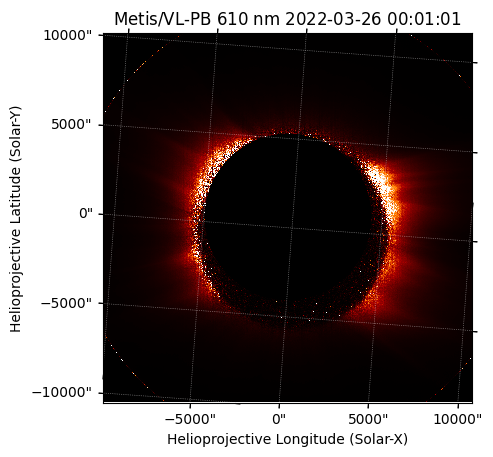

In [ ]:
# ------------------------------------------------------------
# Load a Metis Level-2 map
# ------------------------------------------------------------

# Select which file and which FITS extension to plot

i = 0          # index of the file in 'downloaded_files' (0 = first file)
extension = 0  # FITS extension to load
               # 0 = main science image (Level-2 calibrated data)

# Create a Metis Map object from the selected FITS file
#    This loads the image as a SunPy Map and applies Metis-specific metadata.
Metis_map = sunpy.map.Map(downloaded_files[i])[extension]

# ------------------------------------------------------------
# 5.1 Basic Metis map plot
# ------------------------------------------------------------
#    SunPy automatically handles WCS axes, titles, and orientation.
Metis_map.plot()

# (Optional alternative)
# Metis_map.peek()    # # Quick interactive preview

In [ ]:
### Inspect Metis FITS metadata
# You can access all header keywords associated with the selected FITS extension.
# See the Metis Data Product Description Document for a detailed description.
# This is useful for checking exposure time, filter, WCS information, calibration flags, etc.

print(Metis_map.meta)

('simple': 'True')
('bitpix': '-32')
('naxis': '2')
('naxis1': '2048')
('naxis2': '2048')
('extend': 'True')
('longstrn': 'OGIP 1.0')
('filename': 'solo_L2_metis-vl-pb_20220326T000101_V01.fits')
('file_raw': '2022-03-26T00.19.38.313934Z-VL_IMAGE.raw')
('parent': 'solo_L1_metis-vl-image_20220326T000203_V01.fits, solo_L1_metis-vl-image_20220326T000142_V01.fits, solo_L1_metis-vl-image_20220326T000122_V01.fits, solo_L1_metis-vl-image_20220326T000101_V01.fits')
('apid': '1084')
('date': '2022-10-13T12:42:15.79')
('date-obs': '2022-03-26T00:01:01.256')
('date-beg': '2022-03-26T00:01:01.256')
('date-avg': '2022-03-26T00:10:42.268')
('date-end': '2022-03-26T00:20:23.281')
('timesys': 'UTC')
('timrder': '0.0')
('timsyer': '0.0')
('obt_beg': '701567949.07855')
('obt_end': '701569111.10197')
('level': 'L2')
('origin': 'Metis EGSE')
('creator': 'metis_l2_prep_vl_polariz.pro')
('vers_sw': '3.1.1 | 2.0.5')
('vers_cal': 'LTP06_1.0.2')
('version': '01')
('obsrvtry': 'Solar Orbiter')
('telescop': 'SOLO

Refine the plot by:

- masking the occulting disk,
- adding solar limb and heliographic grid,
- applying a contrast stretch to improve visibility of faint structures.


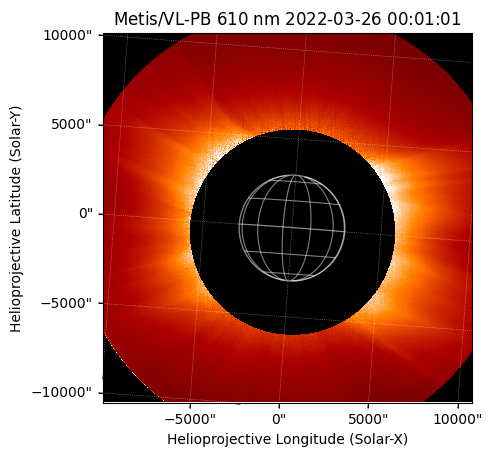

In [ ]:
# ------------------------------------------------------------
# Mask the Metis occulting disk
# ------------------------------------------------------------
# This applies a mask to the region corresponding to the internal/externals occulters.
# Pixels where mask_val = 0 will be hidden in the final visualization.
Metis_map.mask_occs(mask_val=0)

# Adding the solar limb and a heliographic grid helps contextualise
# the field of view and improves spatial interpretation.
Metis_map.draw_limb(color = 'white', alpha = 0.5)
Metis_map.draw_grid(color = 'white', alpha = 0.5, grid_spacing = 30*u.deg)

# ------------------------------------------------------------
# Enhance visibility with custom display scaling
# ------------------------------------------------------------
# Apply ImageNormalize to adjust display limits and
# improve contrast. The vmax is set to the 99.9th percentile to
# suppress outliers, while PowerStretch enhances faint coronal features.
from astropy.visualization import ImageNormalize, PowerStretch
import numpy as np
Metis_map.plot_settings['norm'] = ImageNormalize(
                                                vmin=0,
                                                vmax=np.percentile(Metis_map.data, 99.9),
                                                stretch=PowerStretch(0.2)
                                                )
# Display the final plot
Metis_map.plot()

## Map Rotation

It is also possible to **rotate the Metis map** to align it with a chosen reference frame  
(e.g., solar north up, spacecraft roll angle, or image axes).

This is especially useful when comparing Metis observations with:

- other Solar Orbiter instruments (EUI, SoloHI, PHI), or  
- remote-sensing instruments on other spacecraft (SOHO/LASCO, STEREO/COR2, SDO/AIA).  

Below is an example showing how to rotate a Metis map using SunPy’s built-in `rotate()` method.

For additional options and details, refer to the *SunPy Map Rotation* documentation.


solar orbitermetisvl-pb


<CoordinatesMap with 2 world coordinates:

  index aliases    type   unit    wrap   format_unit visible
  ----- ------- --------- ---- --------- ----------- -------
      0     lon longitude  deg 180.0 deg         deg     yes
      1     lat  latitude  deg      None         deg     yes

>

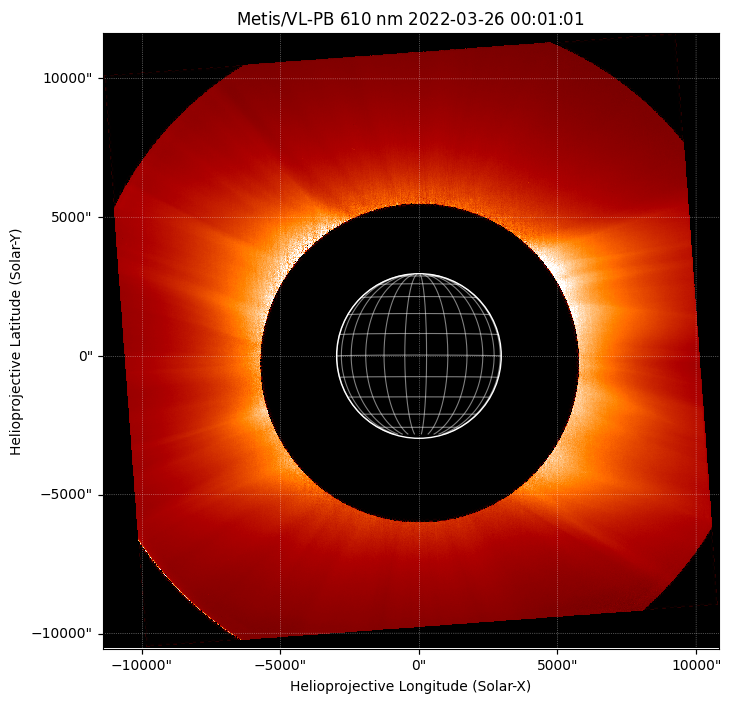

In [ ]:
# ------------------------------------------------------------
# Rotate the Metis map
# ------------------------------------------------------------
# By default, rotate() aligns solar north to the top of the image.
# You can also provide a custom angle (e.g., rotate(angle=30*u.deg)).

Metis_map_rotated = Metis_map.rotate()

# ------------------------------------------------------------
# Plot the rotated map
# ------------------------------------------------------------
# The rotated image is now aligned to the reference frame defined by SunPy.

plt.figure(figsize=(8,8))
Metis_map_rotated.plot()

# Add solar limb and heliographic grid for reference
Metis_map_rotated.draw_limb()
Metis_map_rotated.draw_grid()

## Download EUI FSI Data for Joint Metis–EUI Analysis

To build a composite Metis–EUI image, we next download an **EUI Full Sun Imager (FSI) 174 Å** image
from SOAR, using a time range that overlaps with the Metis observation. We use the same `time` interval defined earlier for Metis.
EUI data can be queried in the same way as Metis data using `sunpy.net.Fido`.

In the example below, we download an EUI/FSI 174 Å image from a time that matches
(or is close to) the Metis observation used above.


In [ ]:
# Select the Solar Orbiter instrument EUI
instrument = a.Instrument("EUI")

# Use the same time range (UTC) as the Metis observation (already defined above as 'time')
# This ensures good temporal alignment between the two datasets.
# (adjust manually if you want a closer temporal match)
# time = a.Time("2022-03-25 01:00:00", "2022-03-25 01:30:00")

# Select the EUI product: FSI 174 Å Level-2 image
product = a.soar.Product("EUI-FSI174-IMAGE")
# Define the data processing level (0 = raw, 1 = calibrated, 2 = science-ready)
level = a.Level(2)

# Perform the query on the SOAR database
result = Fido.search(instrument & time & product & level)
print(f"Found {len(result[0])} matching EUI/FSI files.")

# Download the first matching file
downloaded_files_EUI = Fido.fetch(result[0][0])
print(downloaded_files_EUI[0])

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

solo_L2_eui-fsi174-image_20220326T000845212_V02.fits:   0%|          | 0.00/5.76M [00:00<?, ?B/s]

/root/sunpy/data/solo_L2_eui-fsi174-image_20220326T000845212_V02.fits



**Reproject EUI onto the Metis frame**

To combine EUI and Metis observations in a single view, the two images must share a common **coordinate system** and **projection**.
Since both instruments observe the corona from Solar Orbiter but with different optical geometries, pixel grids, and plate scales, we need to **reproject the EUI map onto the Metis WCS frame**.
We use a **spherical screen** model (`SphericalScreen`) and construct a new WCS header that:

- uses the **Metis observer** and observation time,  
- uses the **EUI pixel scale**,  
- defines a common **helioprojective** coordinate system.


In [ ]:
from sunpy.coordinates import SphericalScreen
from astropy.coordinates import SkyCoord ##
import astropy.units as u ##
# Create a EUIMap object from the base SunPy map
EUI_map = sunpy.map.Map(downloaded_files_EUI[i])

## Define the target coordinate (Metis reference frame)
# We use the Metis observer, same observation time, and same helioprojective frame.

projected_coord = SkyCoord(0*u.arcsec, 0*u.arcsec,
                           obstime=Metis_map.observer_coordinate.obstime,
                           frame='helioprojective',
                           observer=Metis_map.observer_coordinate,
                           rsun=EUI_map.coordinate_frame.rsun)

# Build a WCS header for the reprojected EUI map
projected_header = sunpy.map.make_fitswcs_header(EUI_map.data.shape,
                                                 projected_coord,
                                                 scale=u.Quantity(EUI_map.scale),
                                                 instrument=EUI_map.instrument,
                                                 wavelength=EUI_map.wavelength)

# Perform the reprojection using a spherical screen model
# ------------------------------------------------------------
# SphericalScreen ensures that both images are projected consistently
# onto a common helioprojective surface.
with SphericalScreen(EUI_map.observer_coordinate):
    EUI_map_reprojected = EUI_map.reproject_to(projected_header)

**Build a Metis–EUI Composite Image**

We now overlay the Metis VL map on top of the reprojected EUI 174 Å image.  
We use:

- the parameter `zorder` to control drawing order
  - zorder = 0  → plotted first (background)
  -   zorder = 1  → plotted on top
  
  Here, EUI is plotted first, and Metis is layered above it.
  
- transparent NaNs for Metis,  
- separate contrast stretches for the two datasets.


INFO:sunpy:Using image-based autoalignment


INFO: Using image-based autoalignment [sunpy.map.mapbase]


<CoordinatesMap with 2 world coordinates:

  index aliases    type   unit    wrap   format_unit visible
  ----- ------- --------- ---- --------- ----------- -------
      0     lon longitude  deg 180.0 deg         deg     yes
      1     lat  latitude  deg      None         deg     yes

>

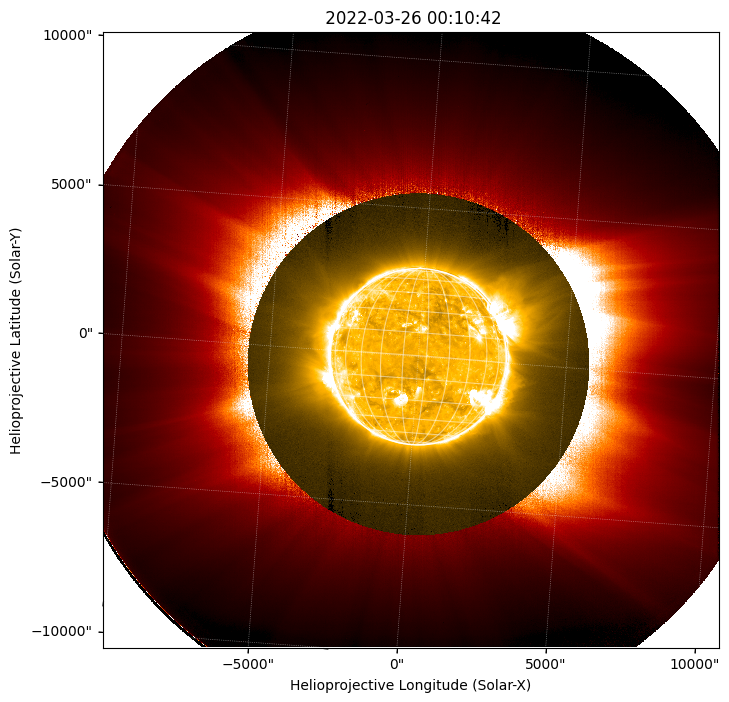

In [ ]:
# ------------------------------------------------------------
# Combined Plot: Metis (foreground) + Reprojected EUI (background)
# ------------------------------------------------------------

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=Metis_map)

# Ensure Metis occulter region is masked as NaN (transparent)
Metis_map.mask_occs(mask_val=np.nan)

# Copy the colormap to avoid modifying the default SunPy colormap globally
cmap = Metis_map.plot_settings['cmap'].copy()
cmap.set_bad(color=(0, 0, 0, 0))  # RGBA: alpha=0 = transparent
Metis_map.plot_settings['cmap'] = cmap

# ------------------------------------------------------------
# Plot the two maps using custom normalization
# ------------------------------------------------------------
# METIS (foreground)
Metis_map.plot_settings['norm'] = ImageNormalize(
    vmin=np.nanpercentile(Metis_map.data, 5),
    vmax=np.nanpercentile(Metis_map.data, 98),
    stretch=PowerStretch(0.5))
Metis_map.plot(axes=ax, autoalign=True, zorder=1)

# EUI (background)
EUI_map_reprojected.plot_settings['norm'] = ImageNormalize(
    vmin=np.nanpercentile(EUI_map_reprojected.data, 5),
    vmax=np.nanpercentile(EUI_map_reprojected.data, 99),
    stretch=PowerStretch(0.22))
EUI_map_reprojected.plot(axes=ax, autoalign=True, zorder=0)

# ------------------------------------------------------------
# Add context: solar limb + heliographic grid
# ------------------------------------------------------------
Metis_map.draw_limb()
Metis_map.draw_grid()
ax.set_title("Metis VL pB (foreground) + EUI/FSI 174 Å (background)")
#plt.show()

---